# Pyaudio Microphone Streaming Examples

A simple notebook that uses pyaudio to get the microphone audio and feeds this audio then to Silero VAD.

I created it as an example on how binary data from a stream could be feed into Silero VAD.


Has been tested on Ubuntu 21.04 (x86). After you installed the dependencies below, no additional setup is required.

This notebook does not work in google colab! For local usage only.

## Dependencies
The cell below lists all used dependencies and the used versions. Uncomment to install them from within the notebook.

In [3]:
!pip install numpy>=1.24.0
!pip install torch>=1.12.0
!pip install matplotlib>=3.6.0
!pip install torchaudio>=0.12.0
!pip install soundfile==0.12.1
#!apt install python3-pyaudio (linux) or 
!pip install pyaudio #(windows)

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.8 MB/s eta 0:00:0000:0100:01
  Using cached cffi-1.17.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (446 kB)
  Using cached pycparser-2.22-py3-none-any.whl (117 kB)
Defaulting to user installation because normal site-packages is not writeable
  Using cached PyAudio-0.2.14-cp310-cp310-linux_x86_64.whl


## Imports

In [4]:
import io
import numpy as np
import torch
torch.set_num_threads(1)
import torchaudio
import matplotlib
import matplotlib.pylab as plt
import pyaudio

In [5]:
model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=True)

/home/nrogalla/.local/lib/python3.10/site-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /home/nrogalla/.cache/torch/hub/master.zip


In [6]:
(get_speech_timestamps,
 save_audio,
 read_audio,
 VADIterator,
 collect_chunks) = utils

### Helper Methods

In [7]:
# Taken from utils_vad.py
def validate(model,
             inputs: torch.Tensor):
    with torch.no_grad():
        outs = model(inputs)
    return outs

# Provided by Alexander Veysov
def int2float(sound):
    abs_max = np.abs(sound).max()
    sound = sound.astype('float32')
    if abs_max > 0:
        sound *= 1/32768
    sound = sound.squeeze()  # depends on the use case
    return sound

## Pyaudio Set-up

In [8]:
FORMAT = pyaudio.paInt16
CHANNELS = 1
SAMPLE_RATE = 16000
CHUNK = int(SAMPLE_RATE / 10)

audio = pyaudio.PyAudio()

ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_refer) error evaluating name
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5701:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM sysdefault
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No

## Simple Example
The following example reads the audio as 250ms chunks from the microphone, converts them to a Pytorch Tensor, and gets the probabilities/confidences if the model thinks the frame is voiced.

In [9]:
num_samples = 512

Started Recording
Stopped the recording


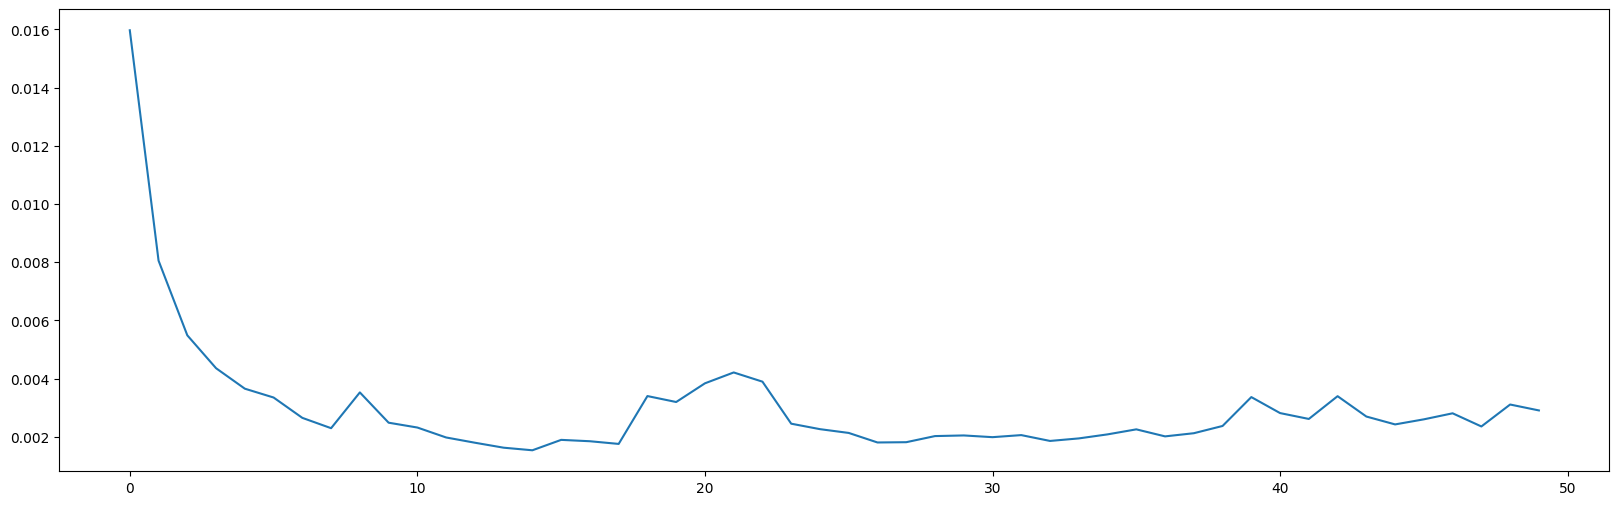

In [10]:
stream = audio.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=SAMPLE_RATE,
                    input=True,
                    frames_per_buffer=CHUNK)
data = []
voiced_confidences = []

frames_to_record = 50

print("Started Recording")
for i in range(0, frames_to_record):
    
    audio_chunk = stream.read(num_samples)
    
    # in case you want to save the audio later
    data.append(audio_chunk)
    
    audio_int16 = np.frombuffer(audio_chunk, np.int16);

    audio_float32 = int2float(audio_int16)
    
    # get the confidences and add them to the list to plot them later
    new_confidence = model(torch.from_numpy(audio_float32), 16000).item()
    voiced_confidences.append(new_confidence)
    
print("Stopped the recording")

# plot the confidences for the speech
plt.figure(figsize=(20,6))
plt.plot(voiced_confidences)
plt.show()

## Real Time Visualization

As an enhancement to plot the speech probabilities in real time I added the implementation below.
In contrast to the simeple one, it records the audio until to stop the recording by pressing enter.
While looking into good ways to update matplotlib plots in real-time, I found a simple libarary that does the job. https://github.com/lvwerra/jupyterplot It has some limitations, but works for this use case really well.


In [ ]:
#!pip install jupyterplot==0.0.3

In [14]:
from jupyterplot import ProgressPlot
import threading

continue_recording = True

def stop():
    input("Press Enter to stop the recording:")
    global continue_recording
    continue_recording = False

def start_recording():
    
    stream = audio.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=SAMPLE_RATE,
                    input=True,
                    frames_per_buffer=CHUNK)

    data = []
    voiced_confidences = []
    
    global continue_recording
    continue_recording = True
    
    pp = ProgressPlot(plot_names=["Silero VAD"],line_names=["speech probabilities"], x_label="audio chunks")
    
    stop_listener = threading.Thread(target=stop)
    stop_listener.start()

    while continue_recording:
    
        audio_chunk = stream.read(num_samples)
    
        # in case you want to save the audio later
        data.append(audio_chunk)
    
        audio_int16 = np.frombuffer(audio_chunk, np.int16);

        audio_float32 = int2float(audio_int16)
    
        # get the confidences and add them to the list to plot them later
        new_confidence = model(torch.from_numpy(audio_float32), 16000).item()
        voiced_confidences.append(new_confidence)
    
        pp.update(new_confidence)


    pp.finalize()

In [ ]:
start_recording()

# Stop after silence

In [30]:
import time
SILENCE_THRESHOLD = 0.2  
SILENCE_DURATION = 2.0  #s

continue_recording = True
silence_detected = False  


def stop():
    
    global continue_recording
    global silence_detected
    while continue_recording and not silence_detected:
        time.sleep(0.1)  # avoid busy waiting
    continue_recording = False  
    


def start_recording():
    stream = audio.open(format=FORMAT,
                        channels=CHANNELS,
                        rate=SAMPLE_RATE,
                        input=True,
                        frames_per_buffer=CHUNK)

    data = []
    voiced_confidences = []
    silence_start = None  # Track when silence starts

    global continue_recording
    global silence_detected
    continue_recording = True
    silence_detected = False

    pp = ProgressPlot(plot_names=["Silero VAD"], line_names=["speech probabilities"], x_label="audio chunks")

    stop_listener = threading.Thread(target=stop)
    stop_listener.start()

    while continue_recording:
        audio_chunk = stream.read(num_samples)

        # In case you want to save the audio later
        data.append(audio_chunk)

        audio_int16 = np.frombuffer(audio_chunk, np.int16)
        audio_float32 = int2float(audio_int16)

        # Get the confidences and add them to the list to plot them later
        new_confidence = model(torch.from_numpy(audio_float32), 16000).item()
        voiced_confidences.append(new_confidence)

        pp.update(new_confidence)

        # Check for silence
        if new_confidence < SILENCE_THRESHOLD:
            if silence_start is None:
                silence_start = time.time()  # Silence start
            elif time.time() - silence_start >= SILENCE_DURATION:
                print("Detected 2 seconds of silence. Stopping recording.")
                silence_detected = True  
                break
        else:
            silence_start = None  # Reset silence timer if voice activity is detected

    pp.finalize()
    stop_listener.join()
start_recording()

Detected 2 seconds of silence. Stopping recording.
